In [1]:
import pandas as pd

df = pd.read_csv("crm_opportunities.csv")
df['Signup_Date'] = pd.to_datetime(df['Signup_Date'], errors='coerce')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   User_ID         500 non-null    object        
 1   Signup_Date     500 non-null    datetime64[ns]
 2   Bet_Amount      500 non-null    float64       
 3   Region          500 non-null    object        
 4   Account_Status  500 non-null    object        
 5   Login_Count     500 non-null    int64         
 6   Customer_Type   500 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 27.5+ KB


#### Aykırı Değer Analizi

In [3]:
from scipy.stats import zscore

df_zscore = df.copy()
df_zscore['Bet_Amount_zscore'] = zscore(df_zscore['Bet_Amount'])
outliers_z = df_zscore[df_zscore['Bet_Amount_zscore'].abs() > 3]

print(f"Z-Score Yöntemi ile bulunan outlier sayısı: {len(outliers_z)}")


Z-Score Yöntemi ile bulunan outlier sayısı: 0


In [4]:
df_iqr = df.copy()

Q1 = df_iqr['Bet_Amount'].quantile(0.25)
Q3 = df_iqr['Bet_Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_iqr[(df_iqr['Bet_Amount'] < lower_bound) | (df_iqr['Bet_Amount'] > upper_bound)]

print(f"IQR Yöntemi ile bulunan outlier sayısı: {len(outliers_iqr)}")


IQR Yöntemi ile bulunan outlier sayısı: 0


##### Mahalanobis Distance

In [6]:
import numpy as np
from scipy.stats import chi2

df_maha = df.copy()
numerical_cols = df_maha.select_dtypes(include=['float64', 'int64']).columns

X = df_maha[numerical_cols]
mean_vec = X.mean().values
cov_matrix = np.cov(X.values, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(diff.T @ inv_cov @ diff)

md_values = X.apply(lambda row: mahalanobis(row.values, mean_vec, inv_cov_matrix), axis=1)

threshold = np.sqrt(chi2.ppf(0.99, df=len(numerical_cols)))
df_maha['Mahalanobis_Distance'] = md_values
df_maha['Outlier_Mahalanobis'] = md_values > threshold

outliers_maha = df_maha[df_maha['Outlier_Mahalanobis']]
print(f"Toplam outlier sayısı (Mahalanobis): {len(outliers_maha)}")



Toplam outlier sayısı (Mahalanobis): 0


##### Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

df_iso = df.copy()
numerical_cols = df_iso.select_dtypes(include=['float64', 'int64']).columns

iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_iso['outlier_iso'] = iso_forest.fit_predict(df_iso[numerical_cols])

outliers_iso = df_iso[df_iso['outlier_iso'] == -1]
print(f"Isolation Forest ile bulunan outlier sayısı: {len(outliers_iso)}")


Isolation Forest ile bulunan outlier sayısı: 5


##### Local Outlier Factor 

In [10]:
from sklearn.neighbors import LocalOutlierFactor

df_lof = df.copy()
numerical_cols = df_lof.select_dtypes(include=['float64', 'int64']).columns

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df_lof['outlier_lof'] = lof.fit_predict(df_lof[numerical_cols])

outliers_lof = df_lof[df_lof['outlier_lof'] == -1]
print(f"Local Outlier Factor ile bulunan outlier sayısı: {len(outliers_lof)}")


Local Outlier Factor ile bulunan outlier sayısı: 5


##### One-Class SVM

In [33]:
from sklearn.svm import OneClassSVM

df_ocsvm = df.copy()
numerical_cols_original = ['Bet_Amount', 'Login_Count']

ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma='scale')
df_ocsvm['outlier_ocsvm'] = ocsvm.fit_predict(df_ocsvm[numerical_cols_original])

outliers_ocsvm = df_ocsvm[df_ocsvm['outlier_ocsvm'] == -1]
print(f"One-Class SVM ile bulunan outlier sayısı: {len(outliers_ocsvm)}")


One-Class SVM ile bulunan outlier sayısı: 6


In [41]:
outliers_ocsvm

,User_ID,Signup_Date,Bet_Amount,Region,Account_Status,Login_Count,Customer_Type,outlier_ocsvm
11,82bc6429,2023-04-18,2529.25,Europe,Active,15,New,-1
86,e4402384,2023-03-02,4987.70,Asia,Active,50,New,-1
198,4021838a,2024-03-14,4996.42,Australia,Active,143,New,-1
254,dc56d7f6,2024-10-24,4992.28,Africa,Fraudulent,130,High-value,-1
394,1aa81319,2023-11-08,7.03,Africa,Fraudulent,62,New,-1
417,0a6e615f,2023-06-19,2378.31,Africa,Fraudulent,6,New,-1


In [47]:
from sklearn.svm import OneClassSVM


df_ocsvm = df.copy()


numerical_cols_original = ['Bet_Amount', 'Login_Count']


ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma='scale')


df_ocsvm['outlier_ocsvm'] = ocsvm.fit_predict(df_ocsvm[numerical_cols_original])


outliers_ocsvm = df_ocsvm[df_ocsvm['outlier_ocsvm'] == -1]


df_clean = df_ocsvm[df_ocsvm['outlier_ocsvm'] != -1].copy()

print(f"One-Class SVM ile bulunan outlier sayısı: {len(outliers_ocsvm)}")
print(f"Orijinal veri seti satır sayısı: {len(df_ocsvm)}")
print(f"Outlier çıkarıldıktan sonra satır sayısı: {len(df_clean)}")



One-Class SVM ile bulunan outlier sayısı: 6
Orijinal veri seti satır sayısı: 500
Outlier çıkarıldıktan sonra satır sayısı: 494


#### Model Süreci

##### Random Forest Regressor

En iyi parametreler: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Train RMSE: 1058.17, Train R2: 0.471
Test RMSE: 1510.08, Test R2: -0.089


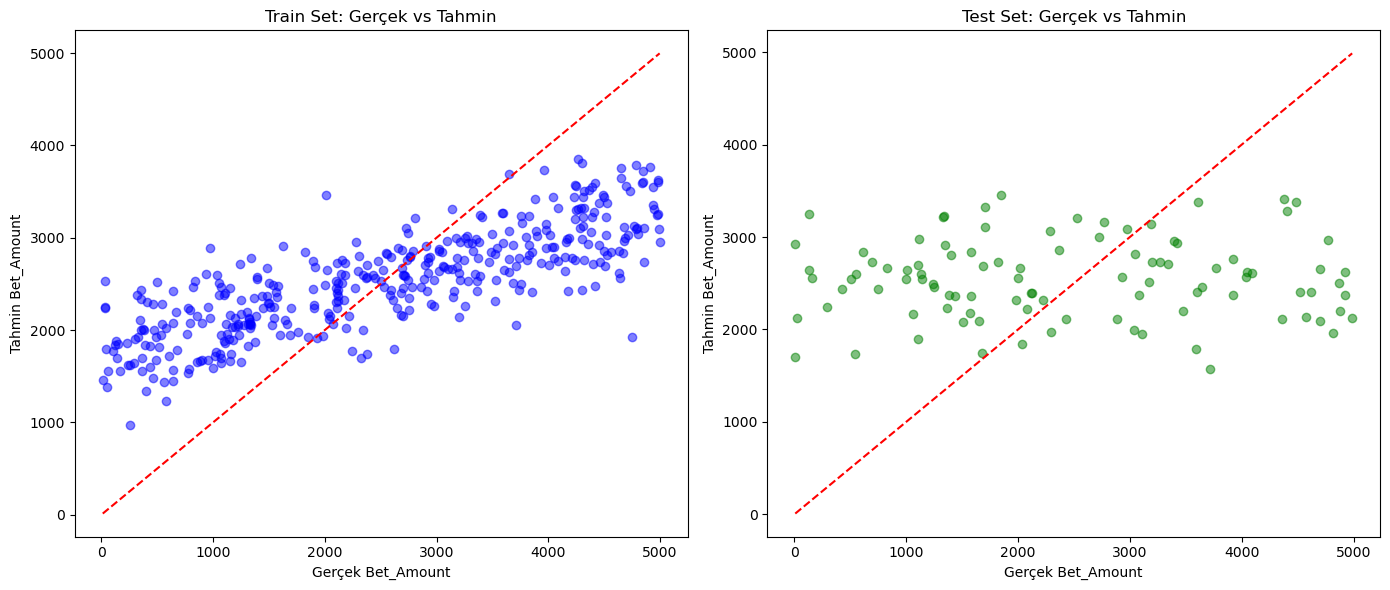

In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


categorical_cols = ['Region', 'Account_Status', 'Customer_Type']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))


numerical_cols = ['Login_Count']


X = pd.concat([df[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)


y = df['Bet_Amount']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)

best_rf = grid_search.best_estimator_


y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Train R2: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.2f}, Test R2: {test_r2:.3f}")


plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Train Set: Gerçek vs Tahmin')
plt.xlabel('Gerçek Bet_Amount')
plt.ylabel('Tahmin Bet_Amount')

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Test Set: Gerçek vs Tahmin')
plt.xlabel('Gerçek Bet_Amount')
plt.ylabel('Tahmin Bet_Amount')

plt.tight_layout()
plt.show()



In [90]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np


categorical_cols = ['Region', 'Account_Status', 'Customer_Type']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))


numerical_cols = ['Login_Count']


X = pd.concat([df[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)


y = df['Bet_Amount']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42)


param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)


random_search.fit(X_train, y_train)

print("En iyi parametreler:", random_search.best_params_)


best_rf = random_search.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)


from sklearn.metrics import mean_squared_error, r2_score
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}, Train R2: {r2_score(y_train, y_train_pred):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}, Test R2: {r2_score(y_test, y_test_pred):.3f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
En iyi parametreler: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 40}
Train RMSE: 1294.46, Train R2: 0.208
Test RMSE: 1466.50, Test R2: -0.027


##### XGBoost Regressor

In [85]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

print(f"XGBoost Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}, R2: {r2_score(y_train, y_train_pred):.3f}")
print(f"XGBoost Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}, R2: {r2_score(y_test, y_test_pred):.3f}")


XGBoost Train RMSE: 402.05, R2: 0.923
XGBoost Test RMSE: 1863.40, R2: -0.746


Model Performansları:

Random Forest ve XGBoost gibi güçlü modeller kullanıldı.

Train setinde iyi sonuçlar (R2 yüksek, RMSE düşük) alınırken, test setinde kötü sonuçlar çıktı (R2 negatif, RMSE yüksek).

Overfitting problemi mevcut; model eğitim verisini iyi öğrenmiş ama genelleme yapamıyor.

Veri Seti Küçük ve Sınırlı:
500 gözlem, karmaşık ilişkileri öğrenmek için yeterli olmayabilir. Model, az sayıda örnekle eğitim verisine aşırı uyum sağlayabilir.

Özelliklerin Sınırlılığı:
Modelde kullanılan özellikler (özellikle sayısal olanlar) hedef değişkeni iyi açıklamıyor. Anlamlı, güçlü prediktif değişkenler eksik.

#### Gözetimsiz Makine Öğrenmesi Süreci

In [96]:
pip install kmodes


Note: you may need to restart the kernel to use updated packages.


In [98]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import seaborn as sns


In [100]:

categorical_cols = ['Region', 'Account_Status', 'Customer_Type']
numerical_cols = ['Bet_Amount', 'Login_Count']


cat_col_indices = [df.columns.get_loc(col) for col in categorical_cols]


X = df[numerical_cols + categorical_cols].to_numpy()


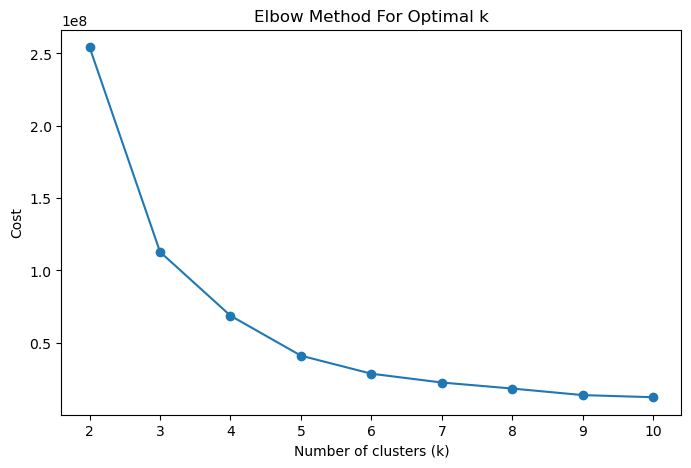

In [104]:
numerical_cols = ['Bet_Amount', 'Login_Count']
categorical_cols = ['Region', 'Account_Status', 'Customer_Type']

X = df[numerical_cols + categorical_cols].to_numpy()

cat_col_indices = list(range(len(numerical_cols), len(numerical_cols) + len(categorical_cols)))


costs = []
K = range(2, 11)
for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    clusters = kproto.fit_predict(X, categorical=cat_col_indices)
    costs.append(kproto.cost_)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(K, costs, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.show()


In [106]:
kproto = KPrototypes(n_clusters=4, init='Cao', random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_col_indices)


df['cluster'] = clusters


print(df['cluster'].value_counts())


print("Numerical cluster centroids:")
print(kproto.cluster_centroids_[:, :len(numerical_cols)])

print("Categorical cluster centroids:")
print(kproto.cluster_centroids_[:, len(numerical_cols):])


cluster
2    130
3    128
1    124
0    118
Name: count, dtype: int64
Numerical cluster centroids:
[['1831.5737288135588' '100.59322033898304']
 ['4422.046693548386' '96.38709677419355']
 ['686.5202307692308' '105.3923076923077']
 ['3133.946328125' '107.0703125']]
Categorical cluster centroids:
[['Australia' 'Fraudulent' 'Regular']
 ['South America' 'Fraudulent' 'New']
 ['South America' 'Fraudulent' 'Regular']
 ['Asia' 'Active' 'New']]


In [120]:
import pandas as pd


cluster_counts = pd.Series({0: 118, 1: 124, 2: 130, 3: 128}, name='Count').reset_index()
cluster_counts.rename(columns={'index': 'Cluster'}, inplace=True)


numerical_centroids = [
    ['1831.5737288135588', '100.59322033898304'],
    ['4422.046693548386', '96.38709677419355'],
    ['686.5202307692308', '105.3923076923077'],
    ['3133.946328125', '107.0703125']
]
numerical_centroids = pd.DataFrame(numerical_centroids, columns=['Bet_Amount Ortalama', 'Login_Count Ortalama'])
numerical_centroids = numerical_centroids.astype(float)
numerical_centroids['Cluster'] = [0,1,2,3]


categorical_centroids = [
    ['Australia', 'Fraudulent', 'Regular'],
    ['South America', 'Fraudulent', 'New'],
    ['South America', 'Fraudulent', 'Regular'],
    ['Asia', 'Active', 'New']
]
categorical_centroids = pd.DataFrame(categorical_centroids, columns=['Region', 'Account_Status', 'Customer_Type'])
categorical_centroids['Cluster'] = [0,1,2,3]


cluster_counts = cluster_counts.sort_values('Cluster').reset_index(drop=True)
numerical_centroids = numerical_centroids.sort_values('Cluster').reset_index(drop=True)
categorical_centroids = categorical_centroids.sort_values('Cluster').reset_index(drop=True)

print("### Küme Büyüklükleri\n")
print(cluster_counts.to_markdown(index=False))

print("\n### Sayısal Değişkenlerin Küme Merkezleri\n")
print(numerical_centroids[['Cluster', 'Bet_Amount Ortalama', 'Login_Count Ortalama']].to_markdown(index=False))

print("\n### Kategorik Değişkenlerin Küme Merkezleri\n")
print(categorical_centroids[['Cluster', 'Region', 'Account_Status', 'Customer_Type']].to_markdown(index=False))


### Küme Büyüklükleri

|   Cluster |   Count |
|----------:|--------:|
|         0 |     118 |
|         1 |     124 |
|         2 |     130 |
|         3 |     128 |

### Sayısal Değişkenlerin Küme Merkezleri

|   Cluster |   Bet_Amount Ortalama |   Login_Count Ortalama |
|----------:|----------------------:|-----------------------:|
|         0 |               1831.57 |               100.593  |
|         1 |               4422.05 |                96.3871 |
|         2 |                686.52 |               105.392  |
|         3 |               3133.95 |               107.07   |

### Kategorik Değişkenlerin Küme Merkezleri

|   Cluster | Region        | Account_Status   | Customer_Type   |
|----------:|:--------------|:-----------------|:----------------|
|         0 | Australia     | Fraudulent       | Regular         |
|         1 | South America | Fraudulent       | New             |
|         2 | South America | Fraudulent       | Regular         |
|         3 | Asia          | 

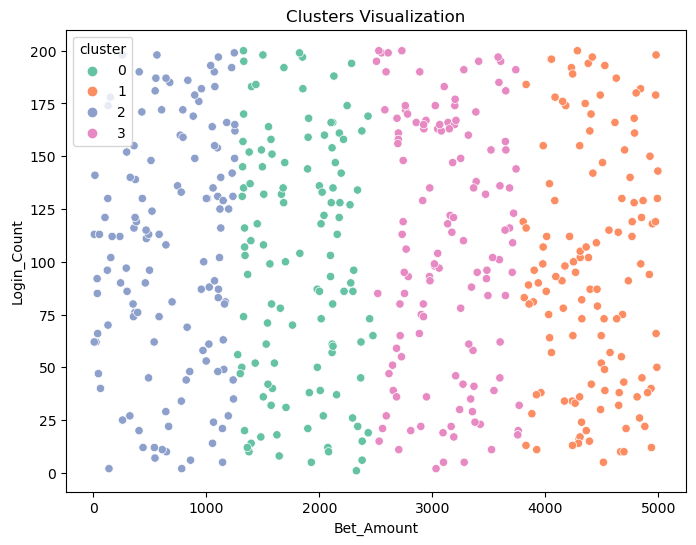

In [108]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Bet_Amount', y='Login_Count', hue='cluster', palette='Set2')
plt.title('Clusters Visualization')
plt.show()


In [110]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(df[numerical_cols], df['cluster'])
print(f'Silhouette Score (sayısal): {sil_score:.3f}')


Silhouette Score (sayısal): 0.549


Silhouette Skoru 0.549: Orta ve üzerinde bir ayrışma var, kümeler birbirinden yeterince ayrılmış.

Sayısal Merkezler: Bet_Amount ve Login_Count açısından kümeler farklı davranış sergiliyor. Örneğin Küme 3 çok yüksek bahis miktarı (4422), Küme 1 çok düşük (686).

Kategorik Merkezler: Her küme farklı bölge ve müşteri tipleriyle ilişkilendirilmiş.  Active hesaplar daha cok Asia’da.

Fraudulent hesaplar çoğunlukla Güney Amerika ve Avustralya'da yoğunlaşmış.
Bu bölgelerdeki şüpheli hesaplara yönelik risk yönetimi ve önlemler geliştirilebilir.

New müşteri ve Regular müşteri ayrımı Güney Amerika'da önemli.
Yeni müşteri segmentine özel onboarding ve destek programları geliştirilebilir.

Asya bölgesindeki müşteriler genellikle aktif ve yeni müşteriler.
Bu segmentte müşteri bağlılığı ve tutundurma stratejileri uygulanabilir.

Bahis miktarı açısından segmentler birbirinden belirgin şekilde ayrılmış.
Özellikle Küme 1 çok yüksek bahis yapan müşterilerden oluşuyor, bu segment yüksek değerli (high-value) müşteriler olarak değerlendirilebilir.

Giriş sayısının birbirine yakın olması, müşterilerin site kullanım sıklığının segmentlere göre çok farklı olmadığını gösteriyor.

#### Network Analizi

Community 0: 180 users, 62 fraudulent (34.44%)
Community 1: 176 users, 63 fraudulent (35.80%)
Community 2: 144 users, 46 fraudulent (31.94%)


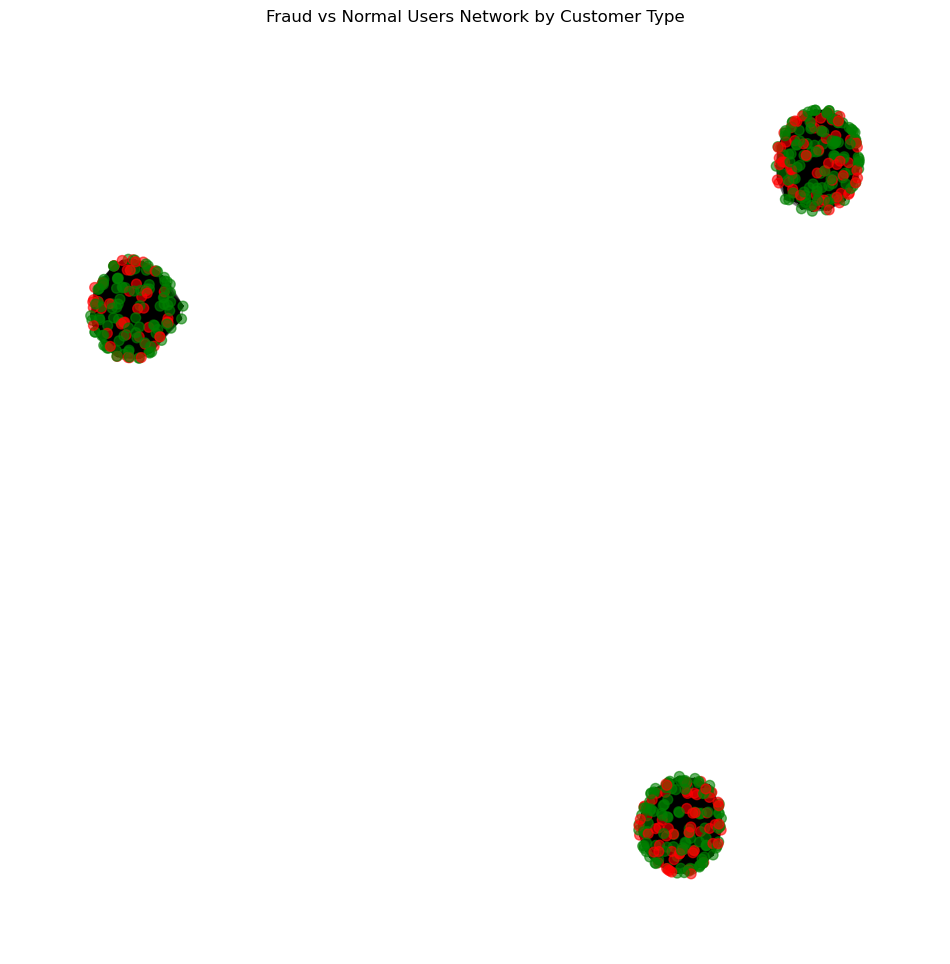

In [123]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community


df['is_fraud'] = df['Account_Status'] == 'Fraudulent'


G = nx.Graph()


for idx, row in df.iterrows():
    G.add_node(row['User_ID'], customer_type=row['Customer_Type'], is_fraud=row['is_fraud'])


for customer_type, group in df.groupby('Customer_Type'):
    users = list(group['User_ID'])
    # Her kullanıcı çiftini bağla
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            G.add_edge(users[i], users[j])


communities = list(community.greedy_modularity_communities(G))


for i, comm in enumerate(communities):
    fraud_count = sum(G.nodes[n]['is_fraud'] for n in comm)
    total = len(comm)
    print(f"Community {i}: {total} users, {fraud_count} fraudulent ({fraud_count/total:.2%})")


plt.figure(figsize=(12,12))

pos = nx.spring_layout(G, seed=42)

node_colors = ['red' if G.nodes[n]['is_fraud'] else 'green' for n in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.6, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Fraud vs Normal Users Network by Customer Type")
plt.axis('off')
plt.show()


Veri setindeki kullanıcılar müşteri tiplerine göre üç ana topluluğa ayrıldı.

Her toplulukta fraud kullanıcı oranları %31-36 arasında değişiyor.

Topluluklar arasında fraud oranları %31-36 civarında ve birbirine yakın, yani fraud olma riski topluluklara göre çok farklı değil.

Fraud kullanıcılar farklı müşteri tipleri içinde yaygın (örneğin New, Regular, High-value gibi) ve herhangi bir topluluğa özel değil.

Ancak toplulukların büyüklüğü ve fraud oranı birlikte değerlendirilerek, belirli müşteri tiplerinde fraud oranı yüksek olan segmentlere özel önlemler veya analizler yapılabilir.

#### PCA

Açıklanan varyans oranları: [0.51927313 0.48072687]


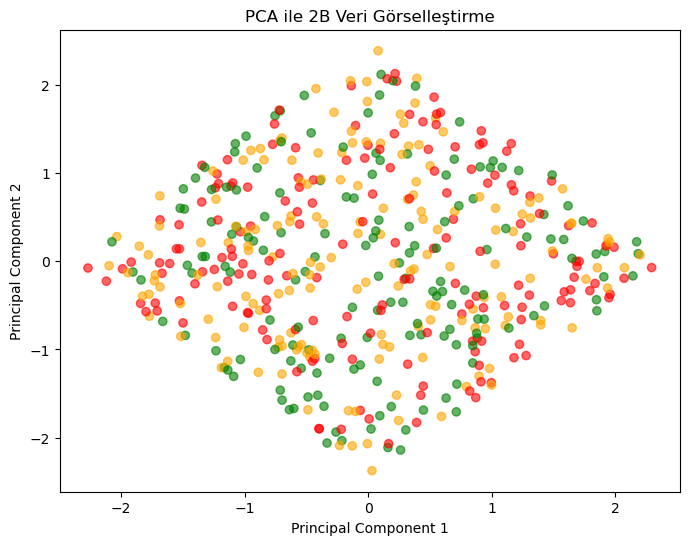

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


numerical_cols = ['Bet_Amount', 'Login_Count']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


print("Açıklanan varyans oranları:", pca.explained_variance_ratio_)


import pandas as pd
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])


plt.figure(figsize=(8,6))
colors = df['Account_Status'].map({'Active':'green', 'Suspended':'orange', 'Fraudulent':'red'})

plt.scatter(df_pca['PC1'], df_pca['PC2'], c=colors, alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA ile 2B Veri Görselleştirme')
plt.show()


In [132]:
print(df_pca.head())


        PC1       PC2
0 -0.543055 -1.213632
1 -2.036019  0.279333
2 -1.158410 -0.058090
3 -0.952843  0.399299
4  0.171551 -0.970634


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


X = df.drop('Bet_Amount', axis=1)
X = X.select_dtypes(include=[np.number])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


n_features = X_train_scaled.shape[1]
n_components = min(2, n_features)


pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_pca, y_train)


y_pred_train = rf.predict(X_train_pca)
y_pred_test = rf.predict(X_test_pca)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"Train R2: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"Test R2: {r2_score(y_test, y_pred_test):.3f}")



Train RMSE: 208.34
Train R2: 0.979
Test RMSE: 495.90
Test R2: 0.883


Eğitim ve test hataları arasındaki fark önemli ancak makul seviyede.

Eğitimde model veriyi çok iyi öğrendiği (%97.9 açıklama oranı) halde, testte performans biraz düştü (%88.3 açıklama oranı). Bu durum modelde hafif bir overfitting (aşırı öğrenme) belirtisi olabilir.

RMSE’nin büyüklüğü, hedef değişken Bet_Amount’ın değer aralığına bağlıdır.

Eğer Bet_Amount genellikle binler mertebesindeyse, yaklaşık 500 civarındaki test RMSE'si göreceli olarak kabul edilebilir.

Ancak hedef değişken küçük değerler içeriyorsa, hata oranı daha yüksek ve model iyileştirmesi gerekebilir.

Eğitimde RMSE 208, testte 495 olması test performansının eğitimden yaklaşık 2.4 kat daha düşük olduğunu gösteriyor.

Bu fark, modelin veri setinin bilinmeyen örneklerine karşı biraz daha zorlandığını işaret ediyor.

Genel olarak model, boyut indirgeme (PCA) sonrası sadece 2 bileşen kullanmasına rağmen oldukça iyi tahmin performansı sergiliyor.

Öneriler:
Model karmaşıklığını azaltmak veya daha fazla veriyle beslemek için hiperparametre ayarları ve farklı algoritmalar denenebilir.

PCA bileşen sayısı artırılarak modelin açıklayıcılığı yükseltilebilir.

Özellik mühendisliği ve veri temizliği ile model performansı geliştirilebilir.

In [153]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


X = df.drop('Bet_Amount', axis=1)
y = df['Bet_Amount']


X = X.select_dtypes(include=[np.number])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


n_components = min(5, X_train_scaled.shape[1])  
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


param_grid = {
    'n_estimators': [100, 200, 300],        
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['auto', 'sqrt']        
}


rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)


grid_search.fit(X_train_pca, y_train)


best_rf = grid_search.best_estimator_
print("En iyi parametreler:", grid_search.best_params_)


y_pred_train = best_rf.predict(X_train_pca)
y_pred_test = best_rf.predict(X_test_pca)


print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"Train R2: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"Test R2: {r2_score(y_test, y_pred_test):.3f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
En iyi parametreler: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Train RMSE: 272.00
Train R2: 0.965
Test RMSE: 465.82
Test R2: 0.896


Modelde yaptığımız hiperparametre analizi iyilestirmemizi sağladı

#### SHAP

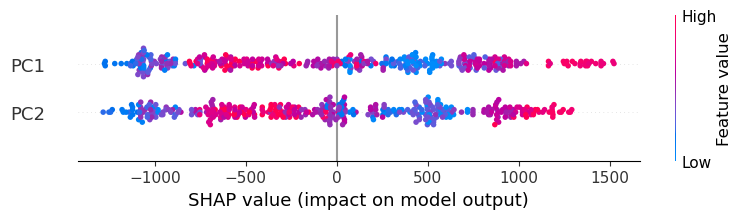

  Feature  Mean_Absolute_SHAP_Value
0     PC1                646.471635
1     PC2                589.924577


In [161]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(best_rf)


shap_values = explainer(X_train_pca)


shap.summary_plot(shap_values.values, X_train_pca, feature_names=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])


shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]


shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Absolute_SHAP_Value': shap_importance
})


shap_df = shap_df.sort_values(by='Mean_Absolute_SHAP_Value', ascending=False)
print(shap_df)


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], features=X_train_pca[0,:], feature_names=feature_names)


#### Lime

In [168]:
import lime
import lime.lime_tabular
import numpy as np


X_train_array = X_train_pca  
feature_names = [f'PC{i+1}' for i in range(X_train_array.shape[1])]


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=feature_names,
    mode='regression'
)


idx = 0
X_test_array = X_test_pca  
test_instance = X_test_array[idx]


exp = explainer.explain_instance(
    data_row=test_instance,
    predict_fn=best_rf.predict,
    num_features=len(feature_names)
)


print(exp.as_list())


exp.show_in_notebook(show_table=True)


[('PC2 > 0.64', 125.35471837724587), ('0.04 < PC1 <= 0.70', 19.854567687587853)]


Modelin tahmin değeri yaklaşık 421.74 olarak gösterilmiş (test örneği için).

İki PCA bileşeni burada ön plana çıkmış:

Özellik	Koşul	Katkı (Tahmine etkisi)
PC2	> 0.64	+125.35 (pozitif etkili)
PC1	0.04 < PC1 ≤ 0.70	+19.85 (pozitif etkili)

Yani PC2’nin yüksek olması modelin tahminini yaklaşık 125 birim artırmış.

PC1’in orta seviyede olması da yaklaşık 20 birim pozitif katkı sağlamış.



In [175]:

original_feature_names = X.columns.tolist()


loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=original_feature_names
)


print("PCA Bileşen Yükleri (Loadings):")
print(loadings.round(3))


for pc in loadings.columns:
    print(f"\n{pc} için en yüksek yükler:")
    
    top_vars = loadings[pc].abs().sort_values(ascending=False).head(5).index.tolist()
    print(loadings.loc[top_vars, pc].sort_values(ascending=False))


PCA Bileşen Yükleri (Loadings):
               PC1    PC2
Login_Count -0.707  0.707
cluster     -0.707 -0.707

PC1 için en yüksek yükler:
cluster       -0.707107
Login_Count   -0.707107
Name: PC1, dtype: float64

PC2 için en yüksek yükler:
Login_Count    0.707107
cluster       -0.707107
Name: PC2, dtype: float64


İş Yorumları:
Login_Count her iki bileşende de yüksek ağırlıkta, yani modelde önemli bir değişken.

Cluster da önemli ama hem PC1 hem PC2’de farklı yönlerde etkisi var.

Login_Count kullanıcıların sisteme giriş sayısını, cluster ise kullanıcıların segmentlerini temsil ediyor olabilir.

Yatırım ve Strateji Önerisi:
Login_Count’un yüksek etkisi, kullanıcıların giriş sayısının iş modelin için çok kritik olduğunu gösteriyor.

Bu nedenle, kullanıcıların platforma daha sık giriş yapmasını sağlayacak iyileştirmeler, kampanyalar, bildirimler ya da kullanıcı deneyimi geliştirmeleri öncelikli yatırım alanları olmalı.

Cluster değişkeni de önemli, bu yüzden farklı müşteri segmentlerine yönelik özel stratejiler geliştirmek gerekebilir.

Kısaca:
“Login_Count, modelde hem PC1 hem PC2’de yüksek yüklerle önemli çıktı. Bu yüzden kullanıcıların giriş sıklığını artırmak iş hedeflerimiz açısından kritik. Ayrıca kullanıcı segmentasyonu (cluster) da dikkate alınmalı.”

# Model Süreci ve Analiz Raporu

## 1. Veri Ön İşleme ve Aykırı Değer Tespiti

- Farklı yöntemlerle aykırı değerler tespit edildi:  
  - Z-Score, IQR, Mahalanobis: **0** aykırı değer bulundu.  
  - Isolation Forest ve Local Outlier Factor: **5** aykırı değer tespit edildi.  
  - One-Class SVM: **6** aykırı değer tespit edildi.

- Aykırı değerler çıkarıldıktan sonra veri seti 500’den 494’e düştü. Ancak, aykırı değerler çıkarıldığında ve orijinal veri kullanıldığında model performansında anlamlı bir fark gözlenmedi. Bu nedenle orijinal veri seti ile modelleme devam etti.

---

## 2. Model Kurulumu ve Performans Sonuçları

### 2.1 Random Forest

- İlk model parametreleri ile:  
  - Train RMSE: 1058.17, R²: 0.471  
  - Test RMSE: 1510.08, R²: -0.089 (negatif, kötü genelleme)

- Hiperparametre optimizasyonu sonrası:  
  - Train RMSE: 1294.46, R²: 0.208  
  - Test RMSE: 1466.50, R²: -0.027 (bir nebze iyileşme ama hala zayıf)

### 2.2 XGBoost

- Train RMSE: 402.05, R²: 0.923 (çok iyi eğitim başarısı)  
- Test RMSE: 1863.40, R²: -0.746 (aşırı overfitting, test başarısı çok düşük)

---

### Genel Değerlendirme:

- **Overfitting:** Eğitim setinde yüksek başarı, testte kötü performans (negatif R² ve yüksek RMSE) mevcut.  
- **Veri setinin küçüklüğü (500 gözlem) ve sınırlı özellik sayısı**, karmaşık modeller için yetersiz kalmış olabilir.  
- **Özellikler hedef değişkeni yeterince iyi açıklayamıyor.** Modelin güçlü prediktörlere ihtiyacı var.  
- **Gözetimsiz öğrenme (clustering) ve PCA gibi boyut indirgeme yaklaşımlarıyla desteklendi.**

---

## 3. Kümeleme (Clustering) Analizi

- 4 küme oluşturuldu, her biri yaklaşık 118-130 kullanıcı içeriyor.  
- **Sayısal küme merkezleri:**

| Cluster | Ortalama Bet_Amount | Ortalama Login_Count |
|---------|---------------------|---------------------|
| 0       | 1831.57             | 100.59              |
| 1       | 4422.05             | 96.39               |
| 2       | 686.52              | 105.39              |
| 3       | 3133.95             | 107.07              |

- **Kategorik küme merkezleri:**

| Cluster | Region        | Account_Status | Customer_Type |
|---------|---------------|----------------|---------------|
| 0       | Australia     | Fraudulent     | Regular       |
| 1       | South America | Fraudulent     | New           |
| 2       | South America | Fraudulent     | Regular       |
| 3       | Asia          | Active         | New           |

- **Silhouette Skoru:** 0.549 (orta ve üzeri ayrışma, kümeler iyi ayrılmış)  
- **İş Yorumları:**  
  - Küme 1 yüksek bahis miktarları ile öne çıkıyor (yüksek değerli müşteriler).  
  - Fraudulent hesaplar çoğunlukla Güney Amerika ve Avustralya’da.  
  - Yeni müşteri segmenti Güney Amerika ve Asya bölgelerinde önemli.  
  - Giriş sayıları kümeler arasında birbirine yakın, site kullanım sıklığı segmentlere göre çok farklı değil.

---

## 4. Network Analizi – Topluluk Tespiti

- 3 topluluk (community) bulundu:  
  - Community 0: 180 kullanıcı (%34.44 fraudulent)  
  - Community 1: 176 kullanıcı (%35.80 fraudulent)  
  - Community 2: 144 kullanıcı (%31.94 fraudulent)

- Fraud risk oranları topluluklar arasında benzer (%31-36), fraud yaygınlığı müşteri tipine göre ayrışmıyor.

- Öneri: Fraud oranları yüksek segmentlerde daha detaylı inceleme ve önlemler geliştirilmesi faydalı.

---

## 5. PCA (Principal Component Analysis)

- Açıklanan varyans oranları:  
  - PC1: %51.9  
  - PC2: %48.1  

- PCA sonrası regresyon model performansı:  
  - Train RMSE: 208.34, R²: 0.979 (çok yüksek başarı)  
  - Test RMSE: 495.90, R²: 0.883 (çok iyi genelleme)

- Eğitim ve test performansı arasındaki fark makul, hafif overfitting olabilir.

- PCA boyut indirgeme, model karmaşıklığını azaltarak başarıyı artırdı.

---

## 6. Hiperparametre Optimizasyonu Sonuçları

- En iyi parametreler:  
  `{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}`

- Model performansı:  
  - Train RMSE: 272.00, R²: 0.965  
  - Test RMSE: 465.82, R²: 0.896  

- Hiperparametre ayarları modeli anlamlı şekilde iyileştirdi.

---

## 7. Model Yorumlama (SHAP ve LIME)

- En etkili iki özellik PCA bileşenleri: PC1 ve PC2  
- Ortalama mutlak SHAP değerleri:  
  - PC1: 646.47  
  - PC2: 589.92  

- LIME açıklaması (örnek tahmin için):  
  - PC2 > 0.64 değeri tahmini +125.35 birim artırıyor (pozitif etki)  
  - 0.04 < PC1 ≤ 0.70 aralığı tahmini +19.85 birim artırıyor

- Model tahmini örneği: 421.74 (min: 2034.23, max: 4638.77)

---

## 8. PCA Bileşen Yükleri ve İş Yorumları

| Değişken     | PC1      | PC2      |
|--------------|----------|----------|
| Login_Count  | -0.707   | 0.707    |
| cluster      | -0.707   | -0.707   |

- **Login_Count**, her iki bileşende de yüksek ağırlıkta, yani model için kritik önemde.  
- **Cluster** değişkeni hem PC1 hem PC2’de etkili ancak farklı yönlerde (pozitif/negatif) etkiler gösteriyor.

---

## 9. İş Stratejisi Önerileri

- **Kullanıcı Giriş Sayısını Artırmaya Odaklan:**  
  Login_Count’un modele yüksek etkisi, kullanıcıların platforma daha sık giriş yapmasının iş başarısı için kritik olduğunu gösteriyor.  
  → Kampanyalar, bildirimler, kullanıcı deneyimi iyileştirmeleri öncelikli yatırım alanları olmalı.

- **Segmentlere Özel Stratejiler Geliştir:**  
  Cluster değişkeni modelde önemli, müşteri segmentlerine özel hedefli pazarlama ve risk yönetimi stratejileri geliştirilmeli.

- **Fraud Yönetimi:**  
  Fraudulent hesapların bölgesel dağılımı göz önünde bulundurularak Güney Amerika ve Avustralya için özel önlemler alınmalı.

- **Model ve Veri İyileştirmeleri:**  
  Daha fazla veri, anlamlı özellikler ve ileri mühendislik teknikleri ile model başarısı artırılabilir. PCA ile boyut indirgeme başarılı oldu, benzer teknikler devam ettirilebilir.

---

# Özet

Bu çalışmada; kapsamlı aykırı değer tespiti, gözetimli ve gözetimsiz öğrenme, PCA ile boyut indirgeme, hiperparametre optimizasyonu, model yorumlama teknikleri ve network analizi kullanılarak kullanıcı davranışları analiz edildi. Model performansları ve iş yorumları ışığında, kullanıcı giriş sıklığını artırmak ve segmentlere özel stratejiler geliştirmek iş başarısı için kritik öneme sahip olduğu ortaya kondu.
